In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
class SmoothingSpline:
    def __init__(self, smooth_param=0.5):
        self.Points = []
        self.alpha = None
        self.SMOOTH = smooth_param
    
    def _transition_to_master_element(self, seg_num, x):
        h = self.Points[seg_num + 1] - self.Points[seg_num]
        return 2.0 * (x - self.Points[seg_num]) / h - 1.0
    
    def _basis_function(self, number, ksi):
        if number == 1: return 0.5 * (1 - ksi)
        elif number == 2: return 0.5 * (1 + ksi)
        else: raise ValueError("Error in basis function number")
    
    def initialize(self, x_nodes, y_nodes, p=0.5):
        self.SMOOTH = p
        self.Points = list(x_nodes)
        
        num_segments = len(self.Points) - 1
        self.alpha = np.zeros(num_segments + 1)
        
        a = np.zeros(num_segments + 1)
        b = np.zeros(num_segments + 1)
        c = np.zeros(num_segments + 1)
        
        def assembling(i, x_val, f_val, weight):
            ksi = self._transition_to_master_element(i, x_val)
            
            f1 = self._basis_function(1, ksi)
            f2 = self._basis_function(2, ksi)
            
            b[i] += (1.0 - self.SMOOTH) * weight * f1 * f1
            b[i + 1] += (1.0 - self.SMOOTH) * weight * f2 * f2
            a[i + 1] += (1.0 - self.SMOOTH) * weight * f1 * f2
            c[i] += (1.0 - self.SMOOTH) * weight * f2 * f1
            
            self.alpha[i] += (1.0 - self.SMOOTH) * weight * f1 * f_val
            self.alpha[i + 1] += (1.0 - self.SMOOTH) * weight * f2 * f_val
        
        for i in range(num_segments):
            assembling(i, self.Points[i], y_nodes[i], 1.0)
            assembling(i, self.Points[i + 1], y_nodes[i + 1], 1.0)
            
            h = self.Points[i + 1] - self.Points[i]
            reg_scale = 1.0 + 99.0 * p * p
            reg_weight = self.SMOOTH * reg_scale
            
            b[i] += reg_weight / h
            b[i + 1] += reg_weight / h
            a[i + 1] -= reg_weight / h
            c[i] -= reg_weight / h
        
        if p > 0.8:
            extra_scale = (p - 0.8) / 0.2
            extra_reg = extra_scale * extra_scale * 500.0
            
            for i in range(num_segments):
                h = self.Points[i + 1] - self.Points[i]
                b[i] += extra_reg / h
                b[i + 1] += extra_reg / h
                
        for j in range(1, num_segments + 1):
            if abs(b[j - 1]) < 1e-12:
                avg = np.mean(y_nodes)
                self.alpha.fill(avg)
                return
            
            m = a[j] / b[j - 1]
            b[j] -= m * c[j - 1]
            self.alpha[j] -= m * self.alpha[j - 1]
        
        if abs(b[num_segments]) < 1e-12:
            avg = np.mean(y_nodes)
            self.alpha.fill(avg)
            return
        
        self.alpha[num_segments] /= b[num_segments]
        for j in range(num_segments - 1, -1, -1):
            self.alpha[j] = (self.alpha[j] - c[j] * self.alpha[j + 1]) / b[j]
    
    def evaluate(self, x):
        if len(self.Points) == 0:
            return 0.0
        
        eps = 1e-7
        num_segments = len(self.Points) - 1
        
        for i in range(num_segments):
            if (self.Points[i] <= x <= self.Points[i + 1] or
                abs(x - self.Points[i]) < eps or
                abs(x - self.Points[i + 1]) < eps):
                
                ksi = self._transition_to_master_element(i, x)
                return (self.alpha[i] * self._basis_function(1, ksi) + 
                        self.alpha[i + 1] * self._basis_function(2, ksi))
        
        if x < self.Points[0]:
            return self.alpha[0]
        if x > self.Points[num_segments]:
            return self.alpha[num_segments]
        
        return 0.0

In [18]:
def plot_task5_results():
    """График для пункта 5: исходный и отфильтрованный сигнал"""
    # Чтение данных
    df = pd.read_csv('signal_analysis.csv')
    
    # Создание сплайнов
    indices = df['index'].values
    original_signal = df['original_signal_real'].values
    filtered_signal = df['filtered_signal_real'].values
    
    # Сплайн для исходного сигнала
    spline_original = SmoothingSpline()
    spline_original.initialize(indices, original_signal, 0.01)
    original_smooth = [spline_original.evaluate(x) for x in indices]
    
    # Сплайн для фильтрованного сигнала
    spline_filtered = SmoothingSpline()
    spline_filtered.initialize(indices, filtered_signal, 0.01)
    filtered_smooth = [spline_filtered.evaluate(x) for x in indices]
    
    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(indices, original_smooth, 'b-', linewidth=2, label='Исходный зашумленный сигнал')
    plt.plot(indices, filtered_smooth, 'r-', linewidth=2, label='Сигнал после фильтрации (IDFT)')
    
    plt.title('Фильтрация зашумленного сигнала')
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 500)
    
    plt.tight_layout()
    plt.show()

def plot_task6_results():
    """График для пункта 6: кусочно-постоянный сигнал"""
    # Чтение данных
    df = pd.read_csv('discontinuous_signal.csv')
    
    # Создание сплайнов
    indices = df['index'].values
    signal = df['signal_real'].values
    
    # Сплайн для сигнала
    spline = SmoothingSpline()
    spline.initialize(indices, signal, 0.01)
    signal_smooth = [spline.evaluate(x) for x in indices]
    
    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(indices, signal_smooth, 'b-', linewidth=2, label='Исходный сигнал')
    
    plt.title('Кусочно-постоянный сигнал')
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 500)
    
    plt.tight_layout()
    plt.show()

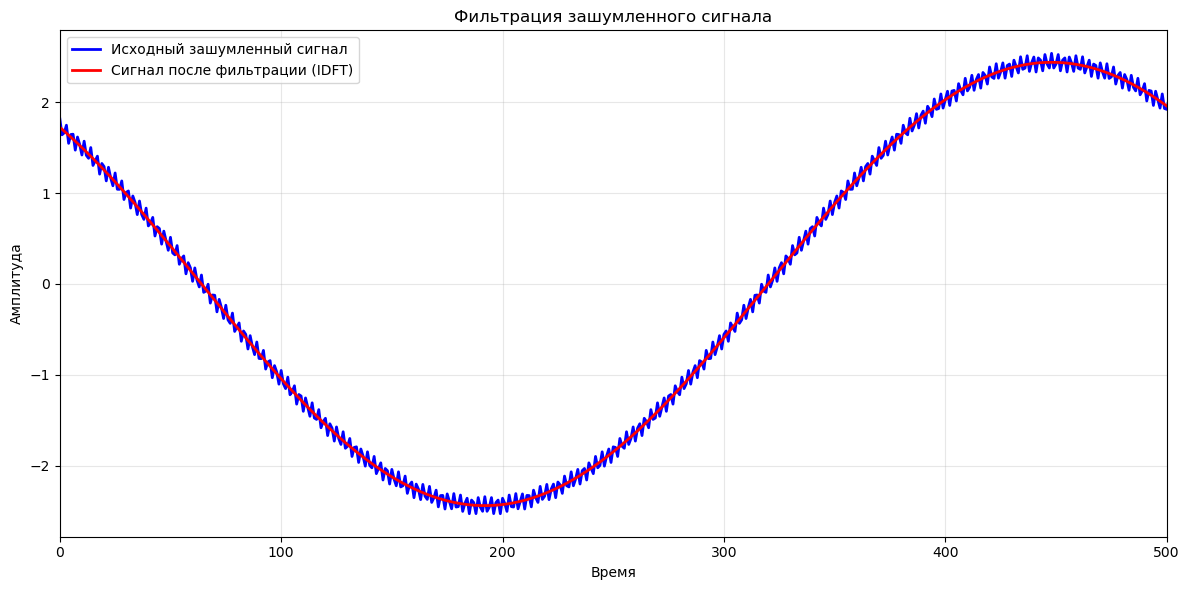

In [19]:
plot_task5_results()

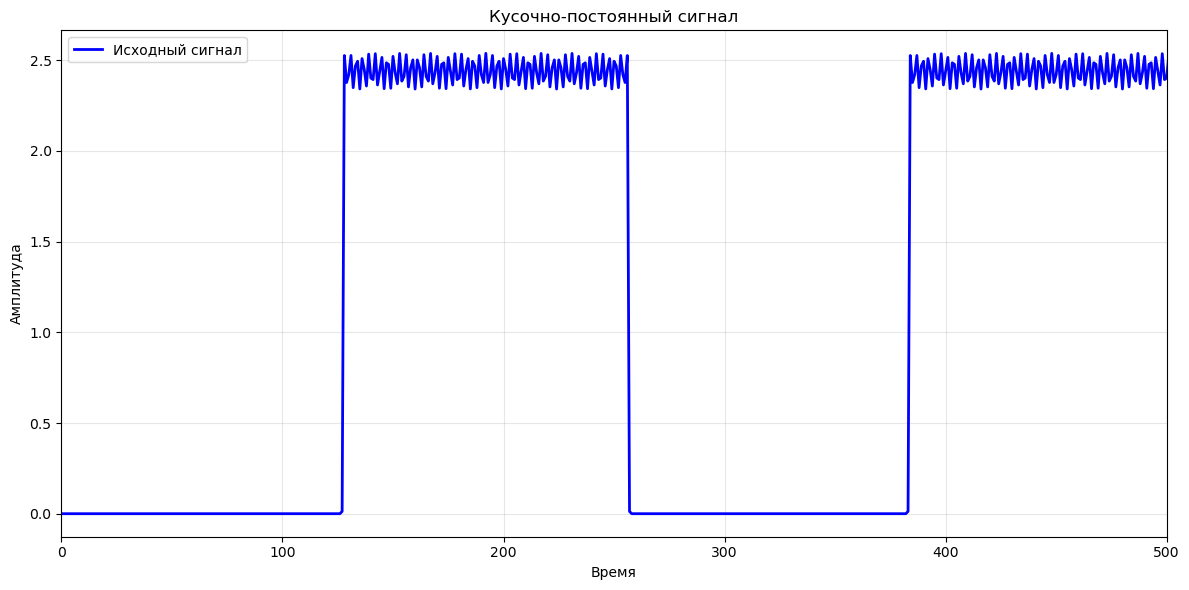

In [20]:
plot_task6_results()